# Stacking Classifier: Learning How to Combine Models

## Objective

Understand how stacking improves generalization by training a meta-model
to optimally combine multiple base learners.

We will:

- Train heterogeneous base models
- Explain out-of-fold prediction logic
- Implement stacking using sklearn
- Compare with individual models
- Analyze bias–variance behavior

## Theoretical Background

Suppose we have base learners:

f₁(x), f₂(x), ..., f_k(x)

Stacking constructs a new feature vector:

z = [f₁(x), f₂(x), ..., f_k(x)]

Then trains a meta-model:

ŷ = g(z)

Key requirement:

The predictions used to train g must be
**out-of-fold predictions** to avoid data leakage.

If not, the meta-model learns from overly optimistic predictions.

In [1]:
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
X, y = make_moons(
    n_samples=500,
    noise=0.3,
    random_state=42
)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

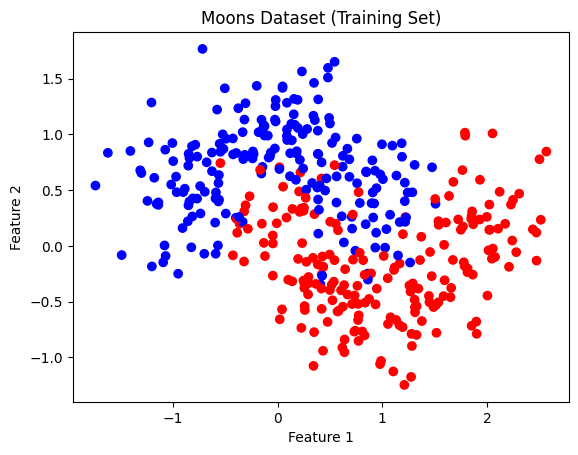

In [3]:
import matplotlib.pyplot as plt

plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap="bwr")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Moons Dataset (Training Set)")
plt.show()

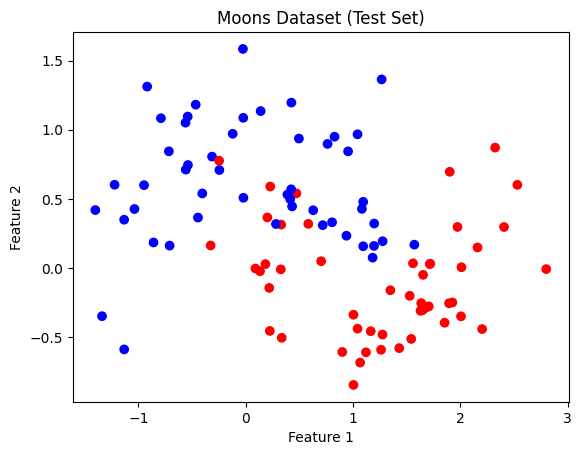

In [4]:
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap="bwr")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("Moons Dataset (Test Set)")
plt.show()

## Base Learners

- Logistic Regression -> High Bias, low variance
- SVC (RBF) -> Flexible nonlinear boundary
- Random Forest -> Low Bias, variance-reduced ensemble

In [5]:
estimators = [
    ("lr", LogisticRegression()),
    ("svc", SVC(probability=True)),
    ("rf", RandomForestClassifier())
]

## Stacking different Models


In [6]:
stack_clf = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(),
    cv=5
)

stack_clf.fit(X_train, y_train)

,"estimators estimators: list of (str, estimator)Base estimators which will be stacked together. Each element of thelist is defined as a tuple of string (i.e. name) and an estimatorinstance. An estimator can be set to 'drop' using `set_params`.The type of estimator is generally expected to be a classifier.However, one can pass a regressor for some use case (e.g. ordinalregression).","[('lr', ...), ('svc', ...), ...]"
,"final_estimator final_estimator: estimator, default=NoneA classifier which will be used to combine the base estimators.The default classifier is a:class:`~sklearn.linear_model.LogisticRegression`.",LogisticRegression()
,"cv cv: int, cross-validation generator, iterable, or ""prefit"", default=NoneDetermines the cross-validation splitting strategy used in`cross_val_predict` to train `final_estimator`. Possible inputs forcv are:* None, to use the default 5-fold cross validation,* integer, to specify the number of folds in a (Stratified) KFold,* An object to be used as a cross-validation generator,* An iterable yielding train, test splits,* `""prefit""`, to assume the `estimators` are prefit. In this case, the estimators will not be refitted.For integer/None inputs, if the estimator is a classifier and y iseither binary or multiclass,:class:`~sklearn.model_selection.StratifiedKFold` is used.In all other cases, :class:`~sklearn.model_selection.KFold` is used.These splitters are instantiated with `shuffle=False` so the splitswill be the same across calls.Refer :ref:`User Guide ` for the variouscross-validation strategies that can be used here.If ""prefit"" is passed, it is assumed that all `estimators` havebeen fitted already. The `final_estimator_` is trained on the `estimators`predictions on the full training set and are **not** cross validatedpredictions. Please note that if the models have been trained on the samedata to train the stacking model, there is a very high risk of overfitting... versionadded:: 1.1 The 'prefit' option was added in 1.1.. note:: A larger number of split will provide no benefits if the number of training samples is large enough. Indeed, the training time will increase. ``cv`` is not used for model evaluation but for prediction.",5
,"stack_method stack_method: {'auto', 'predict_proba', 'decision_function', 'predict'}, default='auto'Methods called for each base estimator. It can be:* if 'auto', it will try to invoke, for each estimator, `'predict_proba'`, `'decision_function'` or `'predict'` in that order.* otherwise, one of `'predict_proba'`, `'decision_function'` or `'predict'`. If the method is not implemented by the estimator, it will raise an error.",'auto'
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for `fit` of all `estimators`.`None` means 1 unless in a `joblib.parallel_backend` context. -1 meansusing all processors. See :term:`Glossary ` for more details.",None
,"passthrough passthrough: bool, default=FalseWhen False, only the predictions of estimators will be used astraining data for `final_estimator`. When True, the`final_estimator` is trained on the predictions as well as theoriginal training data.",False
,"verbose verbose: int, default=0Verbosity level.",0
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse 

In [7]:
# Train the individual classifiers
for name, estimator in estimators:
    estimator.fit(X_train, y_train)
    y_pred = estimator.predict(X_test)
    print(f"{name} Model")
    print(f"Accuracy on train set: {estimator.score(X_train, y_train):.2f}")
    print(f"Accuracy on test set: {estimator.score(X_test, y_test):.2f}")
    print()



lr Model
Accuracy on train set: 0.85
Accuracy on test set: 0.81

svc Model
Accuracy on train set: 0.93
Accuracy on test set: 0.93

rf Model
Accuracy on train set: 1.00
Accuracy on test set: 0.88



In [8]:
print("Stacking Classifier")
print(f"Accuracy on train set: {stack_clf.score(X_train, y_train):.2f}")
print(f"Accuracy on test set: {stack_clf.score(X_test, y_test):.2f}")

Stacking Classifier
Accuracy on train set: 0.95
Accuracy on test set: 0.91


## Bias-Variance Analysis

**Logistic Regression:**
- High bias
- Low variance

**SVC:**
- Balanced bias–variance
- Strong nonlinear fit

**Random Forest:**
- Low bias
- Reduced variance via averaging

**Stacking:**
- Learns optimal combination
- Can reduce both bias and variance
- Works best when base model errors are uncorrelated

## Decision Boundary Visulization

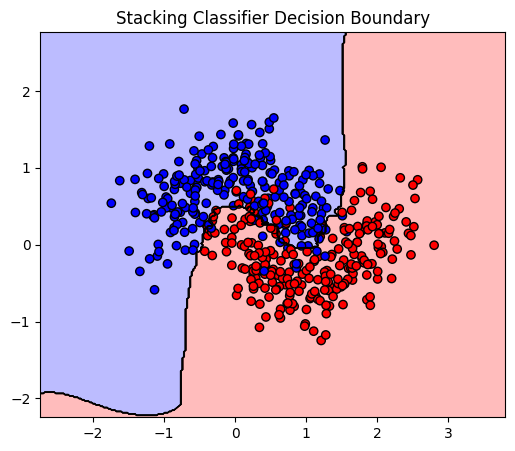

In [10]:
import numpy as np

def plot_decision_boundary(model, X, y, title):
    x0, x1 = np.meshgrid(
        np.linspace(X[:, 0].min() - 1, X[:, 0].max() + 1, 300),
        np.linspace(X[:, 1].min() - 1, X[:, 1].max() + 1, 300)
    )

    X_grid = np.c_[x0.ravel(), x1.ravel()]
    y_pred = model.predict(X_grid).reshape(x0.shape)

    plt.figure(figsize=(6,5))
    plt.contourf(x0, x1, y_pred, alpha=0.3, cmap="bwr")
    plt.contour(x0, x1, y_pred, colors="k", linewidths=0.5)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap="bwr", edgecolor="k")
    plt.title(title)
    plt.show()

plot_decision_boundary(stack_clf, X, y,
                       "Stacking Classifier Decision Boundary")

## Engineering Takeaways
- Stacking uses meta-learning to combine models.
- Out-of-fold predictions prevent data leakage.
- Logistic regression is commonly used as meta-model for stability.
- Stacking improves performance when base models are complementary.
- If one base model dominates, stacking may not improve results.

# Comparison Between Hard Voting, Soft Voting and Stacking

In [11]:
from sklearn.ensemble import VotingClassifier

soft_voting_clf = VotingClassifier(
    estimators=estimators,
    voting="soft"
)

soft_voting_clf.fit(X_train, y_train)

,"estimators estimators: list of (str, estimator) tuplesInvoking the ``fit`` method on the ``VotingClassifier`` will fit clonesof those original estimators that will be stored in the class attribute``self.estimators_``. An estimator can be set to ``'drop'`` using:meth:`set_params`... versionchanged:: 0.21 ``'drop'`` is accepted. Using None was deprecated in 0.22 and support was removed in 0.24.","[('lr', ...), ('svc', ...), ...]"
,"voting voting: {'hard', 'soft'}, default='hard'If 'hard', uses predicted class labels for majority rule voting.Else if 'soft', predicts the class label based on the argmax ofthe sums of the predicted probabilities, which is recommended foran ensemble of well-calibrated classifiers.",'soft'
,"weights weights: array-like of shape (n_classifiers,), default=NoneSequence of weights (`float` or `int`) to weight the occurrences ofpredicted class labels (`hard` voting) or class probabilitiesbefore averaging (`soft` voting). Uses uniform weights if `None`.",None
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for ``fit``.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionadded:: 0.18",None
,"flatten_transform flatten_transform: bool, default=TrueAffects shape of transform output only when voting='soft'If voting='soft' and flatten_transform=True, transform method returnsmatrix with shape (n_samples, n_classifiers * n_classes). Ifflatten_transform=False, it returns(n_classifiers, n_samples, n_classes).",True
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting will be printed as itis completed... versionadded:: 0.23",False
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001


In [14]:
print("Soft Voting Classifier")
print(f"Accuracy on train set: {accuracy_score(y_train, soft_voting_clf.predict(X_train)):.2f}")
print(f"Accuracy on test set: {accuracy_score(y_test, soft_voting_clf.predict(X_test)):.2f}")

Soft Voting Classifier
Accuracy on train set: 0.94
Accuracy on test set: 0.91


In [15]:
hard_voting_clf = VotingClassifier(
    estimators=estimators,
    voting="hard"
)

hard_voting_clf.fit(X_train, y_train)

,"estimators estimators: list of (str, estimator) tuplesInvoking the ``fit`` method on the ``VotingClassifier`` will fit clonesof those original estimators that will be stored in the class attribute``self.estimators_``. An estimator can be set to ``'drop'`` using:meth:`set_params`... versionchanged:: 0.21 ``'drop'`` is accepted. Using None was deprecated in 0.22 and support was removed in 0.24.","[('lr', ...), ('svc', ...), ...]"
,"voting voting: {'hard', 'soft'}, default='hard'If 'hard', uses predicted class labels for majority rule voting.Else if 'soft', predicts the class label based on the argmax ofthe sums of the predicted probabilities, which is recommended foran ensemble of well-calibrated classifiers.",'hard'
,"weights weights: array-like of shape (n_classifiers,), default=NoneSequence of weights (`float` or `int`) to weight the occurrences ofpredicted class labels (`hard` voting) or class probabilitiesbefore averaging (`soft` voting). Uses uniform weights if `None`.",None
,"n_jobs n_jobs: int, default=NoneThe number of jobs to run in parallel for ``fit``.``None`` means 1 unless in a :obj:`joblib.parallel_backend` context.``-1`` means using all processors. See :term:`Glossary `for more details... versionadded:: 0.18",None
,"flatten_transform flatten_transform: bool, default=TrueAffects shape of transform output only when voting='soft'If voting='soft' and flatten_transform=True, transform method returnsmatrix with shape (n_samples, n_classifiers * n_classes). Ifflatten_transform=False, it returns(n_classifiers, n_samples, n_classes).",True
,"verbose verbose: bool, default=FalseIf True, the time elapsed while fitting will be printed as itis completed... versionadded:: 0.23",False
,"penalty penalty: {'l1', 'l2', 'elasticnet', None}, default='l2'Specify the norm of the penalty:- `None`: no penalty is added;- `'l2'`: add a L2 penalty term and it is the default choice;- `'l1'`: add a L1 penalty term;- `'elasticnet'`: both L1 and L2 penalty terms are added... warning:: Some penalties may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionadded:: 0.19 l1 penalty with SAGA solver (allowing 'multinomial' + L1).. deprecated:: 1.8 `penalty` was deprecated in version 1.8 and will be removed in 1.10. Use `l1_ratio` instead. `l1_ratio=0` for `penalty='l2'`, `l1_ratio=1` for `penalty='l1'` and `l1_ratio` set to any float between 0 and 1 for `'penalty='elasticnet'`.",'deprecated'
,"C C: float, default=1.0Inverse of regularization strength; must be a positive float.Like in support vector machines, smaller values specify strongerregularization. `C=np.inf` results in unpenalized logistic regression.For a visual example on the effect of tuning the `C` parameterwith an L1 penalty, see::ref:`sphx_glr_auto_examples_linear_model_plot_logistic_path.py`.",1.0
,"l1_ratio l1_ratio: float, default=0.0The Elastic-Net mixing parameter, with `0 <= l1_ratio <= 1`. Setting`l1_ratio=1` gives a pure L1-penalty, setting `l1_ratio=0` a pure L2-penalty.Any value between 0 and 1 gives an Elastic-Net penalty of the form`l1_ratio * L1 + (1 - l1_ratio) * L2`... warning:: Certain values of `l1_ratio`, i.e. some penalties, may not work with some solvers. See the parameter `solver` below, to know the compatibility between the penalty and solver... versionchanged:: 1.8 Default value changed from None to 0.0... deprecated:: 1.8 `None` is deprecated and will be removed in version 1.10. Always use `l1_ratio` to specify the penalty type.",0.0
,"dual dual: bool, default=FalseDual (constrained) or primal (regularized, see also:ref:`this equation `) formulation. Dual formulationis only implemented for l2 penalty with liblinear solver. Prefer `dual=False`when n_samples > n_features.",False
,"tol tol: float, default=1e-4Tolerance for stopping criteria.",0.0001


In [16]:
print("Hard Voting Classifier")
print(f"Accuracy on train set: {accuracy_score(y_train, hard_voting_clf.predict(X_train)):.2f}")
print(f"Accuracy on test set: {accuracy_score(y_test, hard_voting_clf.predict(X_test)):.2f}")

Hard Voting Classifier
Accuracy on train set: 0.94
Accuracy on test set: 0.90


## Model Comparison Interpretation

### Performance Summary

- **Hard Voting** → Train = 0.94, Test = 0.90  
- **Soft Voting** → Train = 0.94, Test = 0.91  
- **Stacking** → Train = 0.95, Test = 0.91  

---

### Observations

1. **Soft voting slightly outperforms hard voting.**  
   Soft voting aggregates predicted probabilities instead of only final class labels, preserving more information about model confidence.

2. **Stacking achieves the highest training accuracy (0.95).**  
   This indicates slightly higher flexibility due to the meta-model learning how to optimally combine base learners.

3. **Stacking and soft voting have identical test accuracy (0.91).**  
   This suggests limited additional gain from meta-learning on this dataset.

4. **Small train–test gap across ensemble methods**  
   indicates reduced variance and good generalization behavior.

---

### Bias–Variance Interpretation

- **Hard Voting**
  - Reduces variance through majority averaging.
  - Discards probability confidence information.

- **Soft Voting**
  - Further improves stability by averaging probabilities.
  - Produces smoother and more stable decision boundaries.

- **Stacking**
  - Learns an optimal combination:
  
    ŷ = g(f₁(x), f₂(x), f₃(x))
  
  - Can reduce both bias and variance when base models are complementary.
  - May introduce additional variance if the meta-model is too complex.

---

### Key Insight

Ensemble improvement depends on:

Accuracy + Diversity

If one base learner (e.g., SVC here) already captures the data structure well,
additional ensemble layers provide diminishing returns.

---

### Practical Takeaways

- Soft voting is a strong and simple ensemble baseline.
- Stacking helps most when base models make uncorrelated errors.
- Increasing meta-model complexity increases risk of overfitting.
- Ensemble methods primarily improve stability rather than dramatically increasing accuracy when a strong base model already exists.